# Homework 6

Part 1: Softmax

Part 2: Naive Bayes: Bayesian spam filter (discrete date)

Part 3: Probability Questions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Part 1 (3pt)
When computing the output probabilities from margins $x_1,\ x_2,\ \ldots,\ x_C$, often (by analogy with binary case) called *logits*, the exponential terms may be very large or very small. This can cause numerical or overflow errors (try `np.exp(1000)`).

Check that the following formula is correct for an arbitrary $A$:

$$
Softmax_i = \frac{e^{x_i}}{\sum\limits_{c=1}^{C} e^{x_c}} = \frac{e^{x_i-A}}{\sum\limits_{c=1}^{C} e^{x_c-A}}.
$$

A suitable choice for this fixed value $A$ is
$$
A = \underset{c}{\max}\ x_c.
$$

## Q1 (3pt) Write a function `compute_probabilities` that computes Softmax.

In [ ]:
def compute_probabilities(X):
    """
    Computes Softmax, for each vector X[i, :].

    Args:
        X - (n, C) NumPy array (n datapoints each with C features in range (-oo, +oo))
    Returns:
        H - (n, C) NumPy array, where each row H[i,:] = Softmax(X[i,:]) (n features in range [0, 1])
    """
    #YOUR CODE HERE
    pass

In [ ]:
#Test yourself
from scipy.special import softmax
M = np.random.randint(-1000, 1000, size=(30,20))
assert np.allclose(compute_probabilities(M), softmax(M, axis=1))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

From the conditional probability formula, we know that
$$
p(y=c|x) = \frac{p(x, y=c)}{p(x)} = \frac{p(x|y=c)p(y=c)}{p(x)}, \quad c=1,2,3,4.
$$

Because the denominator doesn't depend on $c,$
$$
a(x) = \underset{c}{argmax}\ p(y=c|x) = \underset{c}{argmax}\ p(x|y=c)p(y=c).
$$

# Part 2 (11pt)
In this Question, you will apply Naive Bayes classifier to build a spam filter. Use dataset from https://www.kaggle.com/datasets/venky73/spam-mails-dataset?select=spam_ham_dataset.csv  It's *Enron email dataset,* a large collection of emails from the Enron Corporation. (If you don't want to loggin to Kaggle, write me an e-mail and I'll send the dataset.)

In [ ]:
#!unzip spam_ham_dataset.csv.zip

Archive:  spam_ham_dataset.csv.zip
  inflating: spam_ham_dataset.csv    


In [ ]:
import pandas as pd
data = pd.read_csv('spam_ham_dataset.csv')

texts = data['text'].values
target = data['label_num'].values
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

### Preprocessing and tokenization

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

Apply `CountVectorizer()` to the training data.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vec = CountVectorizer()

In [ ]:
X_train_bow = vec.fit_transform(texts_train).toarray()
X_test_bow = vec.transform(texts_test).toarray()

Now you have the counts of the words from the bag of words in each e-mail.

__Naive bayes:__ perhaps the simplest model that can solve your problem is the so called Naive Bayes Classifier.
Its a simple probabilistic model that assumes the independence of input features (words' frequencies) and computes the counting probabilities.

For example, if we have a dictionary of $n$ words and a phrase *I’m writing to you because of an investment portfolio of you*, the corresponding vector $x=(x_1,\ldots, x_n)$ will have counts $1$ for *I*, *m*, *writing*, *to*, *because*, *of*, *an*, *investment*, *portfolio*, $2$ for *you*, and $0$ for the rest words.

Let's say you have calculated probabilities (frequencies) of each word in the set of normal e-mails. Then

$$
p(x|y=1) = p('I'|y=1)p('m'|y=1)p('writing'|y=1)p('to'|y=1)p^2('you'|y=1)\ldots
$$

Then you can calculate $p(x|y=0).$ It will be convenient to work with log-probabilities:

$$
\log p(x|y=1) = \log p('I'|y=1)+\log p('m'|y=1)+\log p('writing'|y=1)+\log p('to'|y=1)+2\log p('you'|y=1)\ldots
$$  

In this case, the factors are counts and it can be represented by dot product:

$$
\log p(x|y=1) = x.dot(np.log(p(words|y=1)))
$$

You can do this for the batch of vectors $X$ (as rows):

```X.dot(np.log(p_neg))```

We call negative, if it's not a spam.

If you don't remember the math behind Naive Bayes, read https://scikit-learn.org/stable/modules/naive_bayes.html to help refresh your memory.

For every word we will calculate its frequency in spam and in ham, it will be $p(word|y=1)$ and $p(word|y=0)$. To avoid devisions by zero instead of the formula
$$
p(word|y) =\frac{\#word \text{ in class y}}{\text{total # words in class } y}
$$
use
$$
p(word|y) =\frac{\delta+\#word \text{ in class y}}{\delta\cdot\text{vocabulary length} + \text{total # words in class } y}
$$

We will use $\delta =1$.

## Q2 (8pt) Write the class for Naive Bayes

In [ ]:
delta = 1.0
class BinaryNaiveBayes:
#     delta = 1.0  # add this to all word counts to smoothe probabilities

    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        # first, compute marginal probabilities of every class, p(y=c) for c = 0,1
        self.p_y = #(<YOUR CODE: probability of y=0 and of y=1 in this order>)


        # count occurences of each word in texts with label 0 (non-spam) and label 1 (spam) separately
        word_counts_negative = #<YOUR CODE HERE>
        word_counts_positive = #<YOUR CODE HERE>
        # ^-- both must be vectors of size vocab_size.

        # finally, lets use those counts to estimate p(x | y = c) for c = 0, 1

        #<YOUR CODE HERE>

        self.p_x_given_negative = #<...>
        self.p_x_given_positive = #<...>
        # ^-- both must be of size vocab_size; and don't forget to use self.delta!!!

        return self

    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
        # compute scores for positive and negative classes separately.
        # We don't use denomenator p(y|X) = p(X|y)p(y)/p(X)
        # these scores should be proportional to log-probabilities of the respective target {0, 1}
        # X.dot(np.log(self.p_x_given_negative*self.p_y[0])) = X.dot(np.log(self.p_x_given_negative)) + np.log(self.p_y[0])

        score_negative = #<...>
        score_positive = #<...>

        return np.stack([score_negative, score_positive], axis=-1)

    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)

In [ ]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [ ]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

Model accuracy: 0.971
Well done!


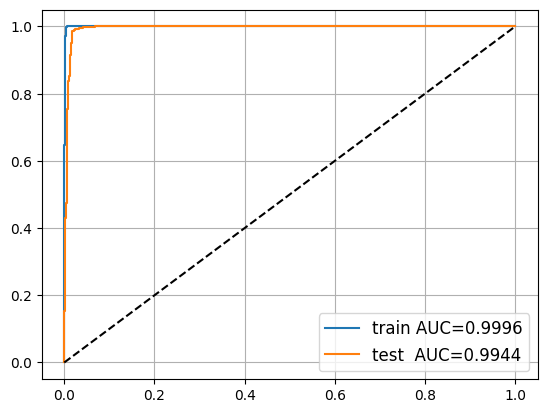

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

Okay, it definitely learned *something*. Now let's figure out what exactly it learned. The simplest way to do that is by highlighting which words have a greatest ratio of positive to negative probability or vice versa. (The log of that fraction is called *logit.*) Here are top-25 words that have the __highest__ ratio of ${p(x_i | y=0)} \over {p(x_i | y=1)}$.

In [ ]:
bow_vocabulary = vec.get_feature_names_out()

In [ ]:
probability_ratio = 1/(naive_model.p_x_given_positive/naive_model.p_x_given_negative)
top_negative_words = bow_vocabulary[np.argsort(probability_ratio)[:25]]
assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[list(bow_vocabulary).index(word)]})")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, naive_model.predict(X_test_bow))

## Q3 (1pt)
Now, let's do it with the built-in function and compare results

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
model = #<YOUR CODE HERE - train a built-in Naive Bayes>

In [ ]:
np.mean(y_test==model.predict(X_test_bow))

## Q4 (2pt)
Now lets try something less prehistoric: __Logistic Regression__. It turns out, if you're using silicon instead of an abacus, you can find model weights by optimizing the log-probability of the answer. Though, of course, you don't even need to write it by hand anymore. Let's sklearn it!

You can play with parameter $C=$ in LogisticRegression, it plays similar role as in SVM allowing slightly negative margins.

In [ ]:
from sklearn.linear_model import LogisticRegression
bow_model = #<YOUR CODE HERE - train a logistic regression>

Model accuracy: 0.971
Well done!


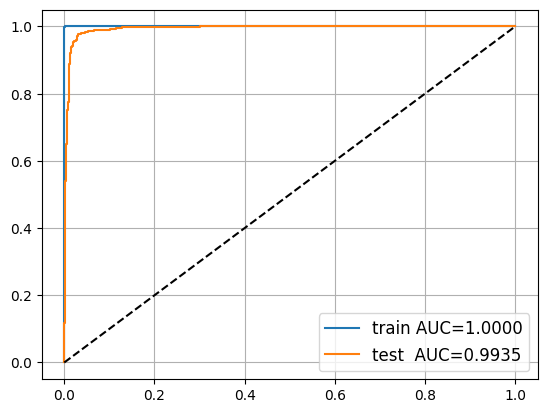

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, bow_model.predict(X_test_bow))

Finally, you can play with threshold to reduce the False Positive predictions, as you did in HW5. But let's better think about

##Q4* (0pt) How to update the Naive Bayes model after getting a new spam classification from a user?

1. We can retrain model (recalculate the frequencies)

2. We can use smoothing
$$
p(w|spam) = \frac{\#w\ in\ spam + 1}{\#words\ in\ spam + \delta Vocab\_size}
$$
(even for words not seen in the new spam e-mails).

# Part 3 (6pt)
## Q5 (5pt)

Discuss the effectiveness of each of the following ML models based on their stated accuracy. Which one is the best overall?

**a.** In a roulette game, a ball is dropped onto a spinning wheel and eventually lands in one of 38 slots. Using a camera and visual cues (the position of the wheel when the ball was dropped and its rotation speed, as well as the position and speed of the ball), an ML model can predict the slot that the ball will land in with an accuracy of 4%.

**b.** A robotic chicken crosses a busy road a thousand times per day. An ML model evaluates traffic patterns and predicts when this chicken can safely cross the street with an accuracy of 99.9%.

**c.** A deadly but curable disease affects 0.01% of the population. An ML model uses the results of a simple lab test as features and predicts this affliction with an accuracy of 99.99%.


## Q6 (1pt)
The KNN model appears simpler than logistic regression, or linear regression for classification, or SVM. Why is the separating surface in KNN more complex than in the case of linear models?